In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors

In [2]:
# fsps imports 
import fsps
from sedpy.observate import getSED
from sedpy.observate import load_filters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
# cosmology imports
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
prettyplot()
pretty_colors = prettycolors()

In [5]:
# some constants to help out
lsun = 3.846e33
pc = 3.085677581467e18 # cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.*np.pi * (pc * 10)**2)

In [6]:
# load SDSS bands
sdss_bands = fsps.find_filter('sdss')
L_sdss = [fsps.get_filter(sdss_band).lambda_eff/1.e4 for sdss_band in ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']]

## iSEDfit galaxy property data

In [7]:
# iSEDfit data 
iSEDfit = mrdfits('/Volumes/750GB/hahn/iGalPros/NSA_iSEDfit/nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz')

#Galaxy 1 : ID = 53999
gal1 = {} 
for key in iSEDfit.__dict__.keys(): 
    gal1[key] = getattr(iSEDfit, key)[53999]

#Galaxy 2 : ID = 18965
gal2 = {} 
for key in iSEDfit.__dict__.keys(): 
    gal2[key] = getattr(iSEDfit, key)[18965]

In [8]:
gal1['ra'], gal1['dec']

(170.69937007606271, 41.732960065591556)

## SDSS opitcal spectra

In [9]:
# import optical spectra from SDSS
spec_gal1 = mrdfits('/Volumes/750GB/hahn/iGalPros/gal1.fits')
spec_gal2 = mrdfits('/Volumes/750GB/hahn/iGalPros/gal2.fits')

(0.37975190394738911, 0.92002568805761842)

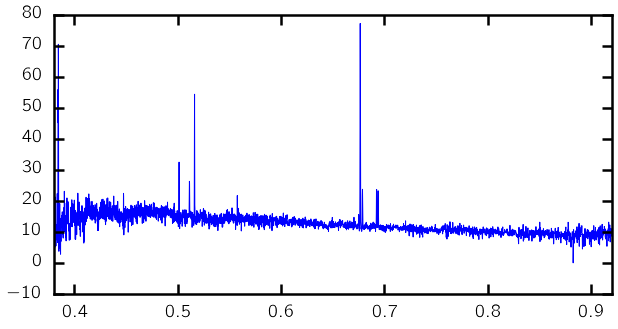

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(10**spec_gal1.loglam/1e4, spec_gal1.flux)
sub.set_xlim([10**(spec_gal1.loglam.min() - 4), 10**(spec_gal1.loglam.max() - 4)])

how well does the CSP generated from iSEDfit best-fits match the observed spectra?

In [11]:
pop = fsps.StellarPopulation(zcontinuous=1)
default_params = dict([(k, pop.params[k]) for k in pop.params.all_params])

In [12]:
def GalSpec(gal_dict, units='ergh'): 
    # reset parameters
    for k in pop.params.all_params:
        pop.params[k] = default_params[k]
    
    # set parameters
    pop.params['sfh'] = 1
    pop.params['tau'] = gal_dict['tau']
    #if np.max(gal_dict['tburst']) > 0: 
    #    pop.params['tburst'] = gal_dict['tburst'][0] # can only include 1 burst
    #    pop.params['fburst'] = gal_dict['fburst'][0]
    pop.params['dust_type'] = 2
    pop.params['dust2'] = 0.92 * gal_dict['av'] * gal_dict['mu'] # ln(10) * 0.4 * A(V)
    pop.params['logzsol'] = np.log10(gal_dict['zmetal']/0.019)
   
    wave, space = pop.get_spectrum(tage=gal_dict['age'], peraa=False)
    
    mass = 10**gal_dict['mstar'] / pop.stellar_mass
    spec = mass*space
    
    d_lum = cosmo.luminosity_distance(gal_dict['z']).value
    d_factor = (d_lum * 1e5)**2
    a = (1. + gal_dict['z'])
    if units == 'ergh': 
        spec = spec * to_cgs * a / d_factor * lightspeed / wave**2 # in erg/s/cm^2/AA
        return wave * a, spec * a
    elif units == 'AB': 
        spec_AB = -2.5 * np.log10(spec * to_cgs * a / d_factor / 1e3 / (3631 * 1e-26)) # AB magnitude
        return wave * a, spec_AB * a

3.66437574648


(0.0, 35.0)

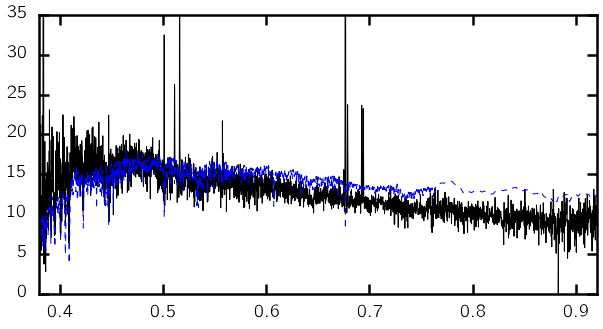

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(10**spec_gal1.loglam/1e4, spec_gal1.flux, c='k', lw=1)

w, sp = GalSpec(gal1, units='ergh')
Mz_fiber = 18.12
Mz_petro = 16.71
f_aperture = 10**(0.4*(Mz_fiber - Mz_petro))
print f_aperture
sub.plot(w/1e4, sp*1e17/1.75, c='b', ls='--')
sub.set_xlim([10**(spec_gal1.loglam.min() - 4), 10**(spec_gal1.loglam.max() - 4)])
#sub.set_xlim([0.1, 1.])
sub.set_ylim([0., 35.])

250.734621054 43.9969142672 0.0316082
4.7424198526


(0.37975190394738911, 0.92002568805761842)

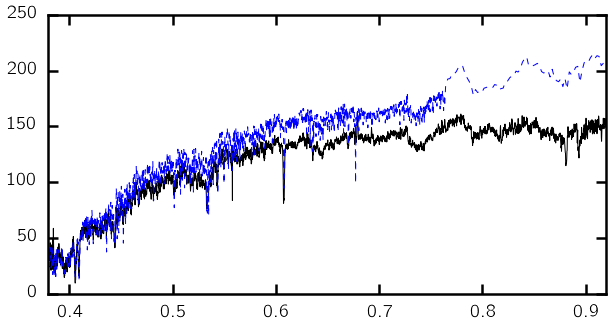

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(10**spec_gal2.loglam/1e4, spec_gal2.flux, c='k', lw=1)
print gal2['ra'], gal2['dec'], gal2['z']
w, sp = GalSpec(gal2, units='ergh')
Mz_fiber = 15.21
Mz_petro = 13.52
f_aperture = 10**(0.4*(Mz_fiber - Mz_petro))
print f_aperture
sub.plot(w/1e4, sp*1e17/f_aperture, c='b', ls='--')
sub.set_xlim([10**(spec_gal1.loglam.min() - 4), 10**(spec_gal1.loglam.max() - 4)])
#sub.set_xlim([0.1, 1.])
#sub.set_ylim([0., 35.])